In [32]:
import pandas as pd
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

In [33]:
df = pd.read_csv('fake_job_postings.csv')

## Most common words in the title of fradulent job postings

In [35]:
f_title=[]
for f_t in df[df.fraudulent==1].title.str.split():
    for word in f_t:
        f_title.append(word)
Counter(f_title).most_common(10)

[('Entry', 95),
 ('Data', 92),
 ('-', 75),
 ('Engineer', 75),
 ('Assistant', 72),
 ('Home', 66),
 ('Payroll', 62),
 ('Clerk', 57),
 ('Positions', 55),
 ('Manager', 54)]

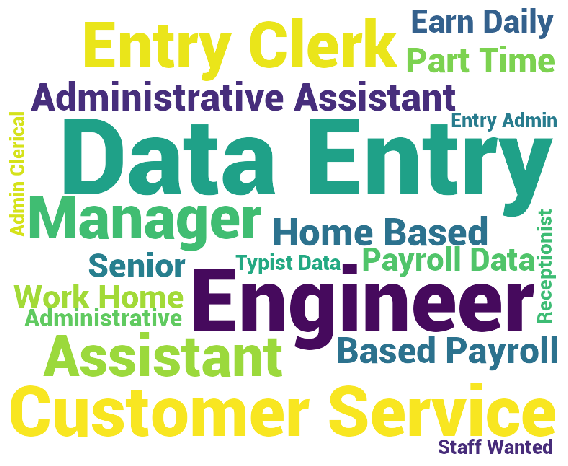

In [38]:
comment_words=''
for val in df[df.fraudulent==1].title: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 

      
    comment_words += " ".join(tokens)+" "
    
wordcloud = WordCloud(width = 769, height = 628, font_step = 1,
                background_color ="rgba(255, 255, 255, 0)", mode="RGBA", max_words = 20,
                stopwords = stopwords, 
                min_font_size = 2,
                     font_path = 'Roboto-Black.ttf').generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (7.69, 6.28)) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig('wordcloud1.png',transparent=True)
plt.show() 

## Topic Modeling on the title of all job postings

In [24]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/eliu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [28]:
stemmer = SnowballStemmer('english')

In [29]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [30]:
processed_docs = df['title'].map(preprocess)

In [32]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 intern
1 market
2 cloud
3 custom
4 product
5 servic
6 video
7 assist
8 commiss
9 machineri
10 account


In [33]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [34]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [35]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.7783273070218419), (1, 0.6278587445788483)]


In [42]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=8, id2word=dictionary, passes=2, workers=2)

In [43]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.152*"develop" + 0.089*"assist" + 0.052*"administr" + 0.052*"offic" + 0.037*"busi" + 0.033*"year" + 0.032*"old" + 0.027*"apprenticeship" + 0.024*"time" + 0.020*"manag"
Topic: 1 
Words: 0.088*"develop" + 0.064*"entri" + 0.047*"data" + 0.044*"posit" + 0.036*"home" + 0.030*"center" + 0.028*"level" + 0.027*"lead" + 0.025*"work" + 0.024*"time"
Topic: 2 
Words: 0.115*"custom" + 0.106*"servic" + 0.089*"engin" + 0.077*"senior" + 0.068*"softwar" + 0.055*"develop" + 0.041*"associ" + 0.033*"specialist" + 0.026*"technic" + 0.021*"repres"
Topic: 3 
Words: 0.114*"account" + 0.069*"manag" + 0.052*"oper" + 0.051*"titl" + 0.043*"execut" + 0.038*"support" + 0.038*"analyst" + 0.037*"data" + 0.031*"busi" + 0.027*"insur"
Topic: 4 
Words: 0.124*"engin" + 0.123*"manag" + 0.080*"design" + 0.058*"product" + 0.044*"project" + 0.030*"senior" + 0.029*"junior" + 0.026*"develop" + 0.022*"closer" + 0.021*"execut"
Topic: 5 
Words: 0.150*"manag" + 0.122*"market" + 0.079*"sale" + 0.036*"intern" + 0.02

In [44]:
import pyLDAvis.gensim
lda_display_bow = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display_bow)

/Users/eliu/opt/anaconda3/envs/usf/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


## Extrac key words from job titles to use as a predictor

In [ ]:
def add_title_flag(df):
    df['title_data_entry'] = [1 if 'entry' in str.lower(title) and 'data' in str.lower(title) 
                              else 0 for title in df.title]
    df['title_home'] = [1 if 'work from home' in str.lower(title) or 'home based' in str.lower(title) 
                        else 0 for title in df.title]
    df['title_dollar'] = [1 if '$' in title else 0 for title in df.title]

## Most common words in real job posting

In [7]:
t_title=[]
for t_t in df[df.fraudulent==0].title.str.split():
    for word in t_t:
        t_title.append(word)
Counter(t_title).most_common(20)

[('Manager', 2008),
 ('-', 1876),
 ('Developer', 1606),
 ('Engineer', 1451),
 ('Sales', 1187),
 ('Senior', 913),
 ('Customer', 888),
 ('Service', 817),
 ('Teacher', 772),
 ('English', 771),
 ('Marketing', 735),
 ('Abroad', 692),
 ('Associate', 621),
 ('Software', 611),
 ('/', 567),
 ('Designer', 540),
 ('Assistant', 530),
 ('&', 509),
 ('and', 508),
 ('Business', 497)]